In [1]:
import datetime
import heliosat
import matplotlib
import numpy as np

from matplotlib import rcParams
rcParams["font.size"] = 12

from matplotlib import pyplot as plt

from scipy.constants import k, mu_0, m_p

c0 = "xkcd:black"
c1 = "xkcd:magenta"
c2 = "xkcd:orange"
c3 = "xkcd:azure"

if __name__ == "__main__":
    t_s = datetime.datetime(2018, 11, 11, 18, tzinfo=datetime.timezone.utc)
    
    t_all = [t_s + datetime.timedelta(minutes=i) for i in range(60 * 24)]
    
    t_b_psp, b_psp = heliosat.PSP().get_data(t_all, "mag", frame="SPP_RTN", cache=False, smoothing=None,
                                             smoothing_scale=5*60, remove_nans=True, return_datetimes=True)
    t_b_psp_, b_psp_ = heliosat.PSP().get_data(t_all, "mag", frame="SPP_RTN", cache=False, smoothing="kernel",
                                               smoothing_scale=5*60, remove_nans=True, return_datetimes=True)
    
    t_p_psp, p_psp = heliosat.PSP().get_data(t_all, "proton", frame="SPP_RTN", cache=False,
                                             smoothing_scale=5*60, remove_nans=True, return_datetimes=True)
    
    comb = []
    
    for i in range(len(t_p_psp)):
        t = t_p_psp[i]
        # find closest time point, within 90 seconds
        deltas = np.array([(abs((t - t_b_psp[j]).total_seconds()), j) for j in range(len(t_b_psp))])
        deltas = deltas[deltas[:, 0] < 90]
        
        sel = np.argmin(deltas[:, 0])
        arg = int(deltas[sel, 1])
        comb.append([i, arg])

/home/aweiss/miniconda3/envs/weiss2020_3dcore/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


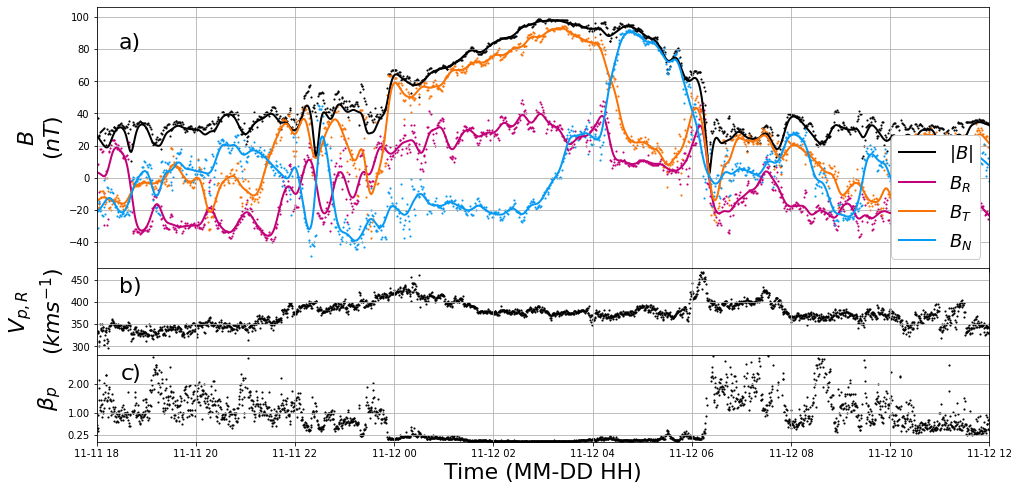

In [3]:
if __name__ == "__main__":    
    fig, (ax_m, ax_v, ax_b) = plt.subplots(3, 1, figsize=(16, 8), sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1, 1]})

    # AX M
    ax_m.scatter(t_b_psp, np.sqrt(np.sum(b_psp**2, axis=1)), color=c0, lw=1, marker=".", s=5)
    ax_m.scatter(t_b_psp, b_psp[:, 0], color=c1, lw=1, marker=".", s=5)
    ax_m.scatter(t_b_psp, b_psp[:, 1], color=c2, lw=1, marker=".", s=5)
    ax_m.scatter(t_b_psp, b_psp[:, 2], color=c3, lw=1, marker=".", s=5)
    
    ax_m.plot(t_b_psp_, np.sqrt(np.sum(b_psp_**2, axis=1)), color=c0, lw=2, label="$|B|$")
    ax_m.plot(t_b_psp_, b_psp_[:, 0], color=c1, lw=2, label=r"$B_R$")
    ax_m.plot(t_b_psp_, b_psp_[:, 1], color=c2, lw=2, label="$B_T$")
    ax_m.plot(t_b_psp_, b_psp_[:, 2], color=c3, lw=2, label="$B_N$")
    
    # AXV
    ax_v.scatter(t_p_psp, p_psp[:, 1], color=c0, lw=1, marker=".", s=5)
    
    # AX B
    b_total = np.sqrt(np.sum(b_psp**2, axis=1))
    beta_nt = np.array([p_psp[i, 0] * p_psp[i, 4]**2 * m_p / 2 / k * 1e6  for (i, j) in comb])
    beta_b = np.array([b_total[j] for (i, j) in comb])
    
    beta = beta_nt / beta_b**2 * 1e6 * k / (1e-18 / 2 / mu_0)
    
    ax_b.scatter(t_p_psp, beta, color=c0, lw=1, marker=".", s=5)
    
    # ==================================================
   
    ax_m.grid(True)
    ax_m.legend(fontsize=18, loc="lower right", framealpha=1)
    ax_m.text(.05, .9, "a)", fontsize=22, transform=ax_m.transAxes, color=c0, horizontalalignment='right', verticalalignment='top')
    ax_m.set_ylabel("$B$\n$(nT)$", fontsize=22)
    
    ax_v.grid(True)
    ax_v.set_ylabel("$V_{p,R}$\n$(kms^{-1})$", fontsize=22)
    ax_v.set_yticks([300, 350, 400, 450])
    
    ax_v.text(.05, .9, "b)", fontsize=22, transform=ax_v.transAxes, color=c0, horizontalalignment='right', verticalalignment='top')
    
    ax_b.grid(True)
    ax_b.set_ylabel("$\\beta_p$", fontsize=22)
    ax_b.set_ylim([0, 3])

    ax_b.set_xlabel("Time (MM-DD HH)", fontsize=22)
    ax_b.set_xlim([datetime.datetime(2018, 11, 11, 18), datetime.datetime(2018, 11, 12, 12)])
    ax_b.set_yticks([0.25, 1, 2])
    
    ax_b.text(.05, .9, "c)", fontsize=22, transform=ax_b.transAxes, color=c0, horizontalalignment='right', verticalalignment='top')